In [1]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
import random

/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module 

# Nearest

In [2]:
df=pd.read_pickle('vd_model.pkl')
#df=df[['teff_calc','Prot','VD_model']]
df=df.rename(columns={"teff_calc": "teff"})
df['teff']

0        4294.608486
1        4028.989654
2        4052.501496
3        3751.604865
4        4318.497349
            ...     
21365    6195.350551
21366    5855.374964
21367    5377.876227
21368    5100.837862
21369    5800.269677
Name: teff, Length: 21370, dtype: float64

generate fake VD data that increases with Prot

In [3]:
def dvfunc(prot,temp):
    return 30*np.log10(df['Prot'])+temp/np.median(temp)*15

In [4]:
#df['dv_true']=dvfunc(df['Prot'],df['teff'])
#df['v_b']=np.random.randn(len(df['Prot']))*df['dv_true']
#df['teff'].hist()
df['dv_true']=df['VD_model']-min(df['VD_model'])
#df['dv_true']=10
df['v_b']=np.random.randn(len(df['Prot']))*df['dv_true']

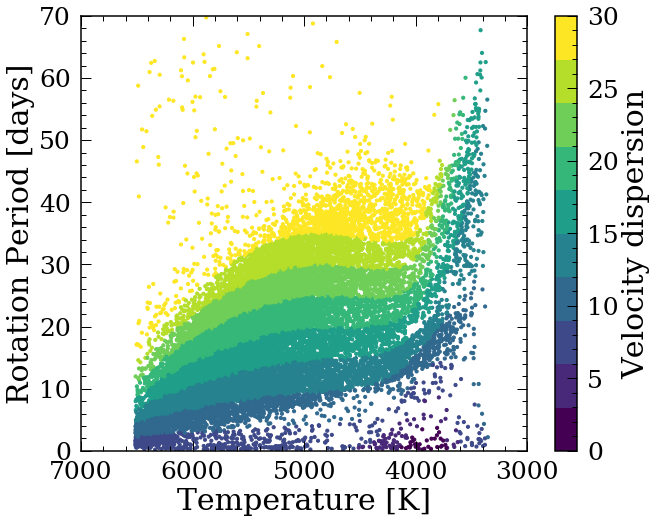

In [5]:
# plot it
v_max,v_min=30,0
cm = plt.cm.get_cmap('viridis',10)
plt.figure(figsize=(10,8))
plt.scatter(df['teff'],df['Prot'],c=df['dv_true'],s=10,vmax=v_max,vmin=0,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.xlim([3000,7000])
plt.ylim([0,70])
plt.gca().invert_xaxis()
plt.ylabel('Rotation Period [days]')

cb=plt.colorbar()
cb.set_label('Velocity dispersion')
plt.savefig('./bintest/ModelIsochrone/Truth_Prot.png')

#df[['teff','Prot','dv_true']].to_pickle('Figures/MockTruth.pkl')

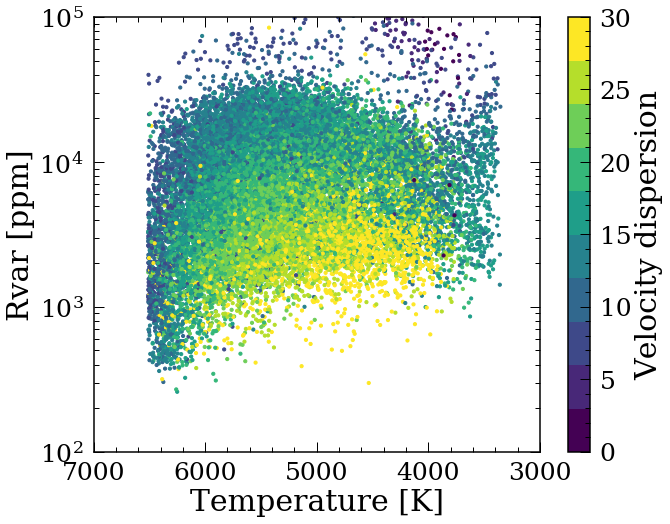

In [13]:
# plot it
v_max,v_min=30,0
cm = plt.cm.get_cmap('viridis',10)
plt.figure(figsize=(10,8))
plt.scatter(df['teff'],df['Rvar'],c=df['dv_true'],s=10,vmax=v_max,vmin=0,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.xlim([3000,7000])
plt.ylim([100,1e5])
plt.gca().invert_xaxis()
plt.ylabel('Rvar [ppm]')
plt.yscale('log')
cb=plt.colorbar()
cb.set_label('Velocity dispersion')
plt.savefig('./bintest/ModelIsochrone/Truth.png')

#df[['teff','Prot','dv_true']].to_pickle('Figures/MockTruth.pkl')

In [14]:
def Calcdv(df,f1,f2,NN):
    Nstars=len(df)
    X_nn = StandardScaler().fit_transform(df[[f1,f2]])
    df[f1+'_norm'],df[f2+'_norm'] = X_nn[:,0], X_nn[:,1]
    
    # initialize velocity dispersion
    df['dv_recover']=np.zeros(Nstars)
    for i in range(Nstars):
        update_progress(i/Nstars)
        teff = df.iloc[i][f1+'_norm']
        Prot = df.iloc[i][f2+'_norm']
        df['dist'] = np.sqrt(np.power(df[f1+'_norm']-teff,2.)+np.power(df[f2+'_norm']-Prot,2.))
        
        # get the clossest stadrs v_b
        NNstars=df.loc[df.sort_values(by=['dist']).iloc[0:NN].index]
    
        #MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))

        #df['dv_recover'].iloc[i]=1.5*MAD
        df['dv_recover'].iloc[i]=np.std(NNstars['v_b'])

In [15]:
df['Rvar_log']=np.log10(df['Rvar'])
NNarrays=[i*10 for i in range(1,30)]
chidq=np.zeros(len(NNarrays))
for i in range(len(NNarrays)):
    update_progress(i/20)
    Calcdv(df,'teff','Rvar_log',NNarrays[i])
    chidq[i]=sum(np.power(df['dv_true']-df['dv_recover'],2))/len(df['dv_recover'])

Progress: [####################] 100.0%


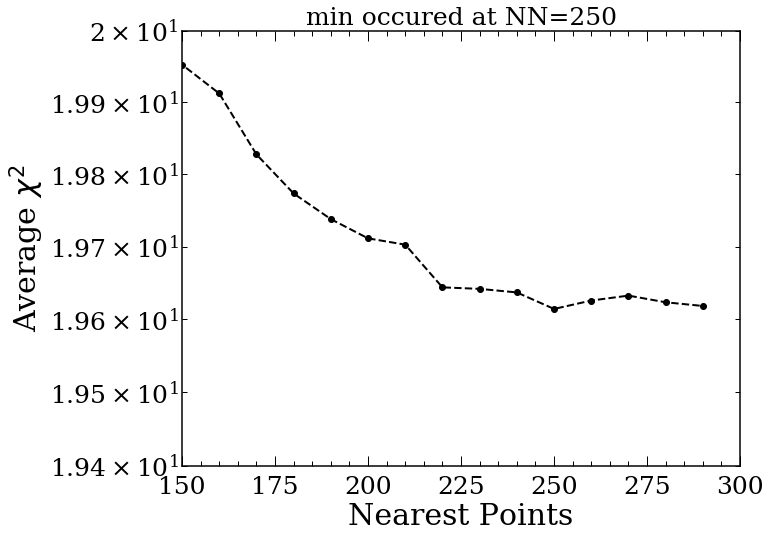

In [40]:
plt.figure(figsize=(10,8))
plt.semilogy(NNarrays,chidq,'ko--')
plt.ylabel('Average $\chi^2$')
plt.xlabel('Nearest Points')
oldchi=chidq[0]
minNN=0
for i in range(len(NNarrays)):
    if chidq[i]<oldchi:
        minNN=NNarrays[i]
        oldchi=chidq[i]
plt.title('min occured at NN=%d'%(minNN),fontsize=25)

np.save('Figures/NN_test_Rvar.npy',NNarrays)
np.save('Figures/NN_test_chidq_Rvar.npy',chidq)
plt.ylim([19.4,20])
plt.xlim([150,300])

plt.savefig('NN_Rvar.png')

In [17]:
df['Rvar_log']=np.log10(df['Rvar'])
Calcdv(df,'teff','Rvar',minNN)

Progress: [####################] 100.0%


In [10]:
df['dv_error']=abs(df['dv_recover']-df['dv_true'])/df['dv_true']
df[['teff','Prot','dv_error']].to_pickle('NNerror.pkl')

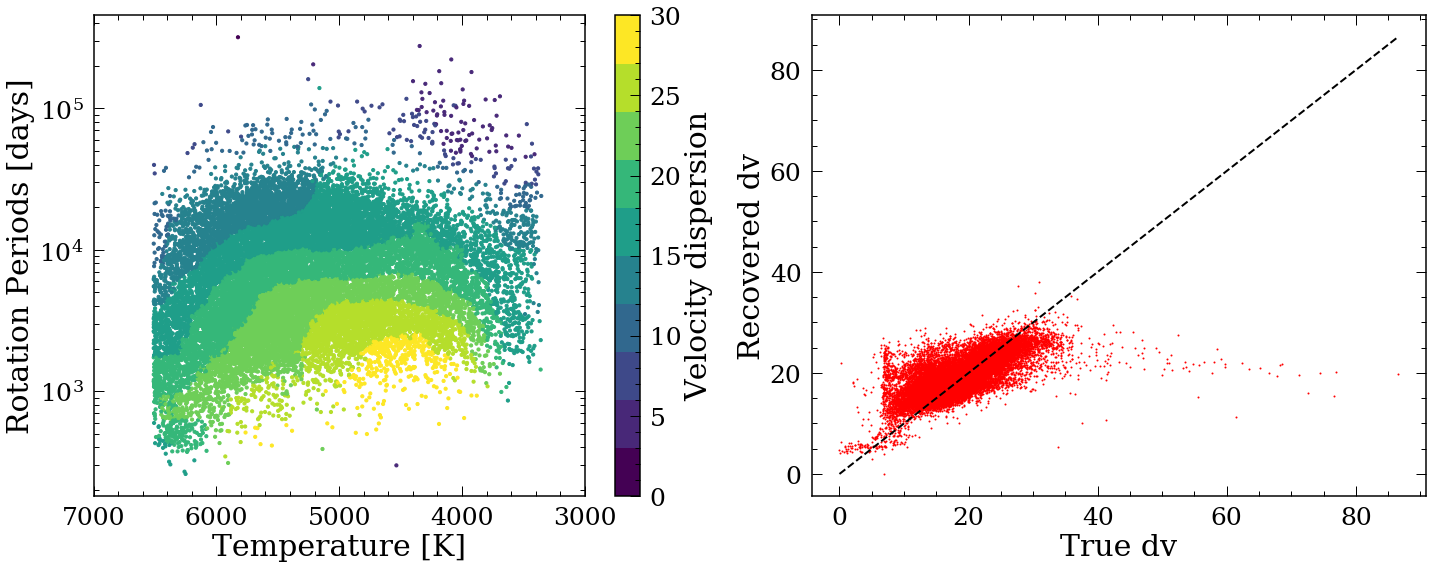

In [32]:
NN=minNN
# plot it
cm = plt.cm.get_cmap('viridis',10)
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)

plt.scatter(df['teff'],df['Rvar'],c=df['dv_recover'],vmax=v_max,vmin=0,s=10,cmap=cm,edgecolors=None)

plt.yscale('log')

plt.xlabel('Temperature [K]')
plt.xlim([3000,7000])
plt.gca().invert_xaxis()
plt.ylabel('Rotation Periods [days]')

cb=plt.colorbar()
cb.set_label('Velocity dispersion')

plt.subplot(1,2,2)
plt.scatter(df['dv_true'],df['dv_recover'],s=1,c='r')
plt.plot([min(df['dv_true']),max(df['dv_true'])],[min(df['dv_true']),max(df['dv_true'])],'k--')
#plt.ylim([0,20])
#plt.xlim([0,20])
plt.ylabel('Recovered dv')
plt.xlabel('True dv')
plt.tight_layout()

df[['teff','Rvar','dv_recover','dv_true','Prot']].to_pickle('Figures/recover_nn_Rvar.pkl')

plt.savefig('./bintest/ModelIsochrone/shift_11_NN_%d'%(NN)+'.png')


# Try bins

In [41]:
def Calcdv_bin(df,f1,f2,binsize_temp,binsize_rot):
    Nstars=len(df)
    
    # initialize velocity dispersion
    df['dv_recover']=np.zeros(Nstars)
    for i in range(Nstars):
        #update_progress(i/Nstars)
        teff = df.iloc[i][f1]
        Prot = df.iloc[i][f2]
        
        
        mask_df1=(df[f1]>teff-binsize_temp/2) & (df[f1]<teff+binsize_temp/2)
        mask_df2=(df[f2]>Prot-binsize_rot/2) & (df[f2]<Prot+binsize_rot/2)
        totmask=mask_df1 & mask_df2

        # get the clossest stadrs v_b
        NNstars=df.loc[totmask]
    
        #MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))

        #df['dv_recover'].iloc[i]=1.5*MAD
        df['dv_recover'].iloc[i]=np.std(NNstars['v_b'])


In [45]:
#bintemps=[50,100,150,200,225,250]
#binprots=[0.07,0.09,0.1,0.11,0.15]
df['Rvar_log']=np.log10(df['Rvar'])
bintemps=[300,400,450,500,550,600,650,700]
#binprots=[0.01,0.05,0.1,0.12,0.15,0.16,0.17,0.19,0.2,0.21,0.22]
binprots=[0.4,0.5,0.7,0.8,1.]

chidq_bin=np.zeros((len(bintemps)*len(binprots)))
temps_a=np.zeros((len(bintemps)*len(binprots)))
bins_a=np.zeros((len(bintemps)*len(binprots)))
"""
chidq_bin=list(chidq_bin)
temps_a=list(temps_a)
bins_a=list(bins_a)
"""
count=0
for i in range(len(bintemps)):
    for j in range(len(binprots)):
        update_progress(((i+1)*(j+1))/(len(chidq_bin)))
        temps_a[count]=bintemps[i]
        bins_a[count]=binprots[j]
        """
        temps_a.append(bintemps[i])
        bins_a.append(binprots[j])
        
        """
        
        Calcdv_bin(df,'teff','Rvar_log',bintemps[i],binprots[j])
        chidq_bin[count]=sum(np.power(df['dv_true']-df['dv_recover'],2))/len(df['dv_recover'])
        #chidq_bin.append(sum(np.power(df['dv_true']-df['dv_recover'],2))/len(df['dv_recover']))
        count=count+1
    

Progress: [####################] 100.0%


In [26]:
j

4

19.404435256811308 506.06060606060606 0.49090909090909096


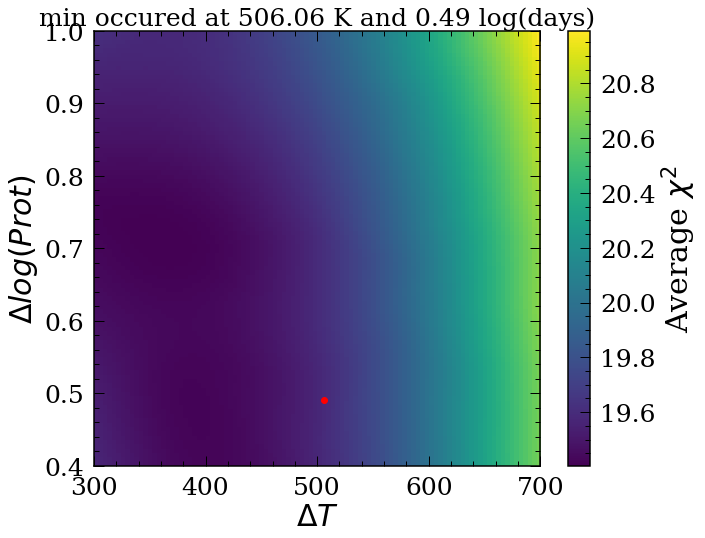

In [46]:
from scipy.interpolate import griddata
temp_g=np.linspace(min(bintemps),max(bintemps),100)
rot_g=np.linspace(min(binprots),max(binprots),100)
grid_x, grid_y = np.meshgrid(temp_g,rot_g)

points=np.zeros((len(temps_a),2))
points[:,0]=temps_a
points[:,1]=bins_a
grid_z1 = griddata(points, chidq_bin, (grid_x, grid_y), method='cubic')


temp_min=0
Prot_min=0
grid_z1=grid_z1.T
oldele=grid_z1[0][0]

finali=0
finalj=0
for i in range(len(grid_z1)):
    for j in range(len(grid_z1[i])):
        if grid_z1[i,j]<oldele:
            finali=i
            finalj=j
            temp_min=temp_g[i]
            Prot_min=rot_g[j]
            oldele=grid_z1[i,j]
print(oldele,temp_min,Prot_min)


plt.figure(figsize=(10,8))
plt.imshow(grid_z1, extent=(min(bintemps),max(bintemps),min(binprots),max(binprots)), origin='lower', aspect='auto')
plt.plot(temp_min,Prot_min,'ro')
plt.xlabel('$\Delta T$')
plt.ylabel('$\Delta log(Prot)$')
#plt.scatter(temps_a,bins_a,c=chidq_bin,s=100,edgecolors='k')
cb=plt.colorbar()
cb.set_label('Average $\chi^2$')
plt.title('min occured at %.2f K and %.2f log(days)'%(temp_min,Prot_min),fontsize=25)
plt.savefig('binsize_rvar.png')

In [53]:
Calcdv_bin(df,'teff','Prot_log',577.27,0.11)
df['dv_error']=abs(df['dv_recover']-df['dv_true'])/df['dv_true']
#df[['teff','Prot','Rvar','dv_error']].to_pickle('binerror.pkl')

(array([11316.,  6794.,  2464.,  1129.,   588.,   347.,   219.,   155.,
          133.,    91.]),
 array([5.11642871e-08, 1.98837396e-02, 3.97674281e-02, 5.96511166e-02,
        7.95348051e-02, 9.94184936e-02, 1.19302182e-01, 1.39185871e-01,
        1.59069559e-01, 1.78953247e-01, 1.98836936e-01]),
 <a list of 10 Patch objects>)

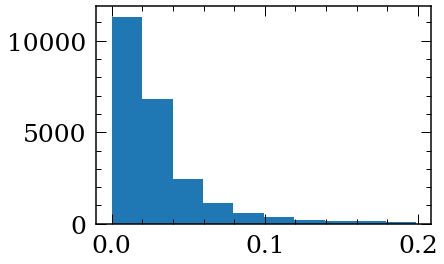

In [248]:
plt.hist(df.loc[df['dv_error']<0.2]['dv_error'])

In [249]:
from sklearn.linear_model import LinearRegression
df=df.replace([np.inf, -np.inf], np.nan)
df=df.dropna(subset=['teff','Prot','dv_error'])

df[['teff','Prot','dv_error']].to_pickle('binerr.pkl')

X = df[['teff','Prot']]
y = df['dv_error']

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))

#from joblib import dump, load
#dump(reg, 'bin_error_lin_model.joblib') 


df_NN=pd.read_pickle('NNerror.pkl')
df_NN=df_NN.replace([np.inf, -np.inf], np.nan)
df_NN=df_NN.dropna(subset=['teff','Prot','dv_error'])
X = df_NN[['teff','Prot']]
y = df_NN['dv_error']
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))

#from joblib import dump, load
#dump(reg, 'NN_error_lin_model.joblib') 

0.017949375947048707
0.009687021628516312


['NN_error_lin_model.joblib']

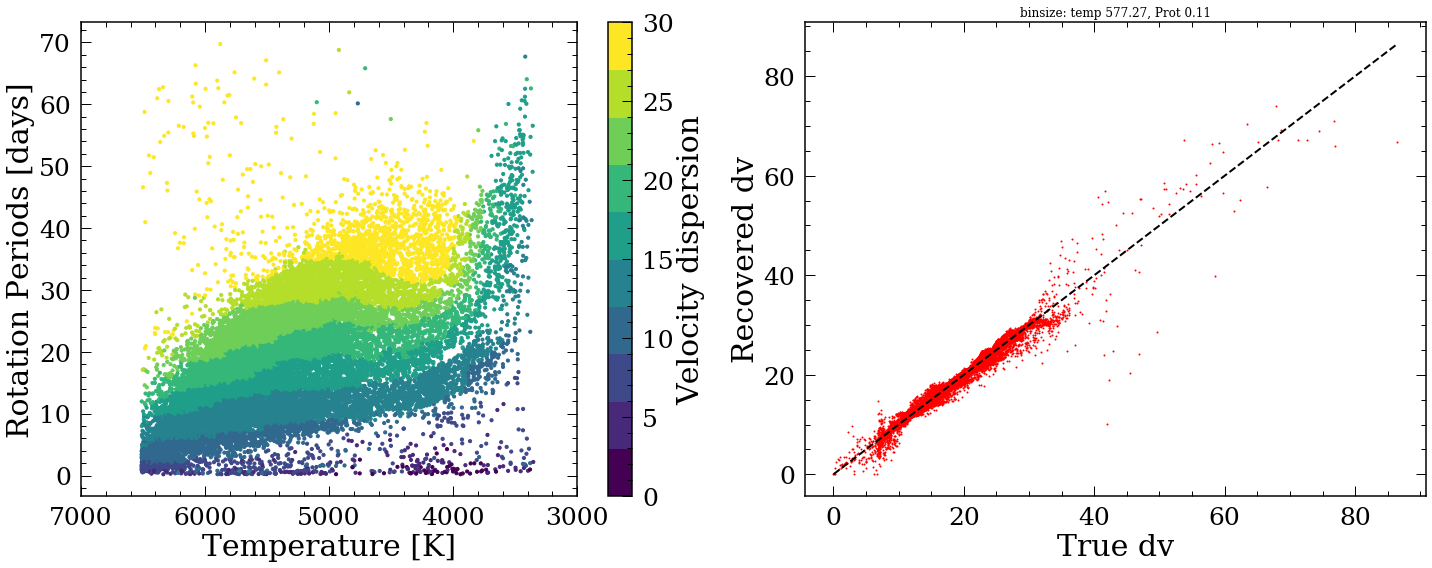

In [54]:
# plot it
bintemp=577.27
binprot=0.11
cm = plt.cm.get_cmap('viridis',10)
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.scatter(df['teff'],df['Prot'],c=df['dv_recover'],vmax=v_max,vmin=0,s=10,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.xlim([3000,7000])
plt.gca().invert_xaxis()
plt.ylabel('Rotation Periods [days]')

cb=plt.colorbar()
cb.set_label('Velocity dispersion')

plt.subplot(1,2,2)
plt.scatter(df['dv_true'],df['dv_recover'],s=1,c='r')
plt.plot([min(df['dv_true']),max(df['dv_true'])],[min(df['dv_true']),max(df['dv_true'])],'k--')
plt.title('binsize: temp %.2f, Prot %.2f'%(bintemp,binprot))
plt.ylabel('Recovered dv')
plt.xlabel('True dv')
#plt.ylim([0,20])
#plt.xlim([0,20])
plt.tight_layout()

df[['teff','Prot','dv_recover','dv_true']].to_pickle('Figures/recover_bin.pkl')
plt.savefig('./bintest/ModelIsochrone/temp_%.2f_Prot %.2f'%(bintemp,binprot)+'.png')



# cluster

In [33]:
default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 500,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}


X = StandardScaler().fit_transform(df[['teff','Prot_log']])
params = default_base.copy()
bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])


connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)

# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")

spectral.fit(X)

SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans',
          coef0=1, degree=3, eigen_solver='arpack', eigen_tol=0.0,
          gamma=1.0, kernel_params=None, n_clusters=500, n_init=10,
          n_jobs=1, n_neighbors=10, random_state=None)

Text(0, 0.5, 'Rotation Periods [days]')

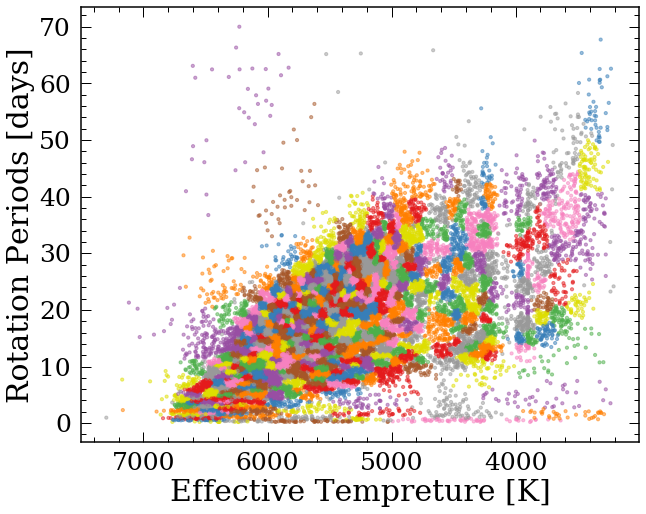

In [38]:

y_pred = spectral.labels_.astype(np.int)

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))

plt.figure(figsize=(10,8))
plt.scatter(df['teff'],df['Prot'],s=10,alpha=0.5,color=colors[y_pred])

plt.xlabel('Effective Temperature [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rotation Periods [days]')

In [56]:
Nstars=len(df)
df['dv_recover']=np.zeros(Nstars)
for i in range(500):
    update_progress(i/500)
    
    mask=(y_pred==i)
    NNstars=df.loc[mask]
    
    MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))
    df['dv_recover'].loc[mask]=1.5*MAD

Progress: [####################] 99.8%


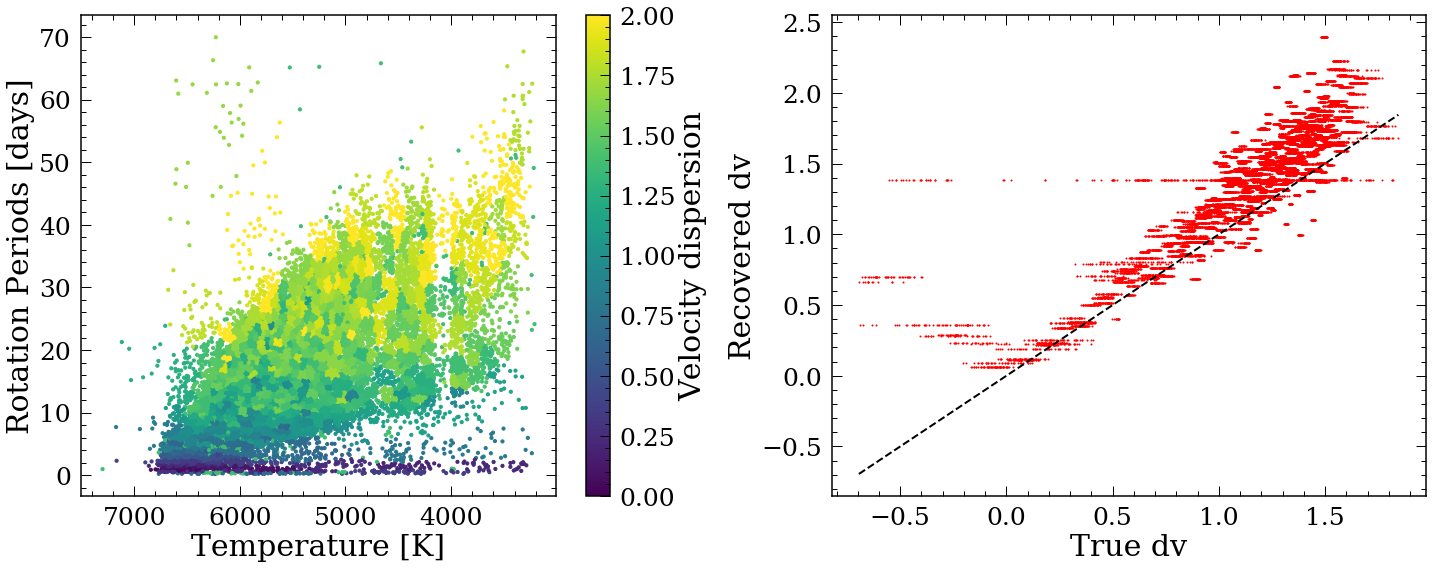

In [57]:
# plot it
cm = plt.cm.get_cmap('viridis')
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.scatter(df['teff'],df['Prot'],c=df['dv_recover'],vmax=2,vmin=0,s=10,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rotation Periods [days]')

cb=plt.colorbar()
cb.set_label('Velocity dispersion')

plt.subplot(1,2,2)
plt.scatter(df['dv_true'],df['dv_recover'],s=1,c='r')
plt.plot([min(df['dv_true']),max(df['dv_true'])],[min(df['dv_true']),max(df['dv_true'])],'k--')
plt.ylabel('Recovered dv')
plt.xlabel('True dv')
plt.tight_layout()


